In [1]:
#default_exp discharge

# Battery Discharging

<br>

### Problem Definition


##### Cost Function

We'll start by defining the cost function for the demand forecasting component of the battery discharge optimisation.

For each day ($𝑑$ = 1, … , 7) the peak percentage reduction is calculated using:

$$R_{d, peak} = 100\left(\frac{\max_{k\in\{32,...,42\}}\left(L_{d, k}\right) - \max_{k\in\{32,...,42\}}\left(L_{d, k}+B_{d, k}\right)}{\max_{k\in\{32,...,42\}}\left(L_{d, k}\right)}\right)$$

Where:
* $L_{d, k}$ is the average power (in MW) over the $k^{th}$ half hour of day $d$, where $k = 1$ would mean the period from midnight to 00:30 AM on the current day, $d$. 
* $B_{d, k}$ is the average power (in MW) over the $k^{th}$ half hour of day $d$, to minimise the peak demand over the evening period (the half hours $𝑘$ = 32 𝑡𝑜 42)

Our goal is to maximise the peak percentage reduction from 3.30PM to 9PM.

<br>

##### Constraints

We also have a number of constraints. The first constraint is on the maximum import and export of energy, in this case:

$$-2.5MW = B_{min} \leq B_{d, k} \leq B_{max} = 2.5MW$$

Secondly the battery cannot charge beyond its capacity, $C_{d, k}$, (in MWh):

$$0 \leq C_{d, k} \leq C_{max} = 6MWh$$

The total charge in the battery at the next time step $C_{d, k+1}$ is related to how much is currently in the battery and how much charged within the battery at time $k$, i.e.

$$C_{d, k+1} = C_{d, k} + 0.5B_{d, k}$$

Finally, the battery must start empty at the start of each day in the test week. I.e. $C_{d,1} = 0$ for $d = 1, … , 7$.

<br>

##### Output

The desired output from the battery discharging optimisation will be an array with 11 values, one for each settlement period. As the battery profile is expressed in terms of the charge all values within the evening time period should be 0 or negative. An example profile is shown below.

```python
battery_evening_profile = [
    0,  # 15:30 - 16:00
    0,  # 16:00 - 16:30
    0,  # 16:30 - 17:00
    0,  # 17:00 - 17:30
    -2, # 17:30 - 18:00
    -2, # 18:00 - 18:30
    -2, # 18:30 - 19:00
    -2, # 19:00 - 19:30
    -2, # 19:30 - 20:00
    0,  # 20:00 - 20:30
    0,  # 20:30 - 21:00
]
```

<br>

### Imports

In [2]:
#exports
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from moepy.lowess import Lowess, quantile_model

from batopt import clean

import os
import random
import FEAutils as hlp

<br>

### User Inputs

In [3]:
raw_data_dir = '../data/raw'
intermediate_data_dir = '../data/intermediate'
cache_data_dir = '../data/nb-cache'

<br>

### Preparing Data

We'll start by loading the datasets, we'll interpolate the weather data which is at an hourly granularity 

In [4]:
df = clean.combine_training_datasets(intermediate_data_dir).interpolate(limit=1)

df.head()

,demand_MW,irradiance_Wm-2,panel_temp_C,pv_power_mw,solar_location1,solar_location2,solar_location3,solar_location4,solar_location5,solar_location6,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6
datetime,,,,,,,,,,,,,,,,
2017-11-03 00:00:00+00:00,2.19,0.0,7.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.560,9.640,7.46,6.680,13.090,13.20
2017-11-03 00:30:00+00:00,2.14,0.0,7.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.625,9.675,7.30,6.475,13.150,13.26
2017-11-03 01:00:00+00:00,2.01,0.0,7.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.690,9.710,7.14,6.270,13.210,13.32
2017-11-03 01:30:00+00:00,1.87,0.0,7.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.715,9.720,7.00,6.090,13.255,13.34
2017-11-03 02:00:00+00:00,1.86,0.0,7.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.740,9.730,6.86,5.910,13.300,13.36


<br>

### Exploratory Demand Analysis

We'll start by exploring the relationship between time of day and demand, in this instance fitting a quantile LOWESS model to get a probabilistic view of likely loads at specific times of day

In [5]:
#exports
def estimate_daily_demand_quantiles(x, y, x_pred = np.linspace(0, 23.5, 100), **model_kwargs):
    # Fitting the model
    df_quantiles = quantile_model(x, y, x_pred=x_pred, **model_kwargs)

    # Cleaning names and sorting for plotting
    df_quantiles.columns = [f'p{int(col*100)}' for col in df_quantiles.columns]
    df_quantiles = df_quantiles[df_quantiles.columns[::-1]]
    
    return df_quantiles

In [6]:
dts = df.index.tz_convert('Europe/London')
x = dts.hour + dts.minute/60
y = df['demand_MW'].values

rerun_daily_demand_model = False
daily_demand_filename = 'daily_demand_quantile_model_results.csv'

if (rerun_daily_demand_model == True) or (daily_demand_filename not in os.listdir(cache_data_dir)):
    df_quantiles = estimate_daily_demand_quantiles(x, y, frac=0.2, num_fits=48, robust_iters=3)
    df_quantiles.to_csv(f'{cache_data_dir}/{daily_demand_filename}')
else:
    df_quantiles = pd.read_csv(f'{cache_data_dir}/{daily_demand_filename}', index_col='x')

df_quantiles.head()

,p90,p80,p70,p60,p50,p40,p30,p20,p10
x,,,,,,,,,
0.000000,2.798489,2.712288,2.646407,2.561911,2.397012,2.106675,1.889666,1.819768,1.770966
0.237374,2.761870,2.675973,2.608709,2.527495,2.369704,2.090690,1.868746,1.795846,1.745769
0.474747,2.725316,2.639735,2.571162,2.493121,2.342462,2.074400,1.847965,1.771846,1.720577
0.712121,2.688708,2.603480,2.533552,2.458632,2.315333,2.057938,1.827455,1.747588,1.695216
0.949495,2.652125,2.567372,2.496137,2.424161,2.288293,2.040857,1.807044,1.723191,1.669598


<br>

We'll now visualise these quantile fits alongside the raw data

N.b. the x values have been slightly jittered in order to make their distribution easier to visualise

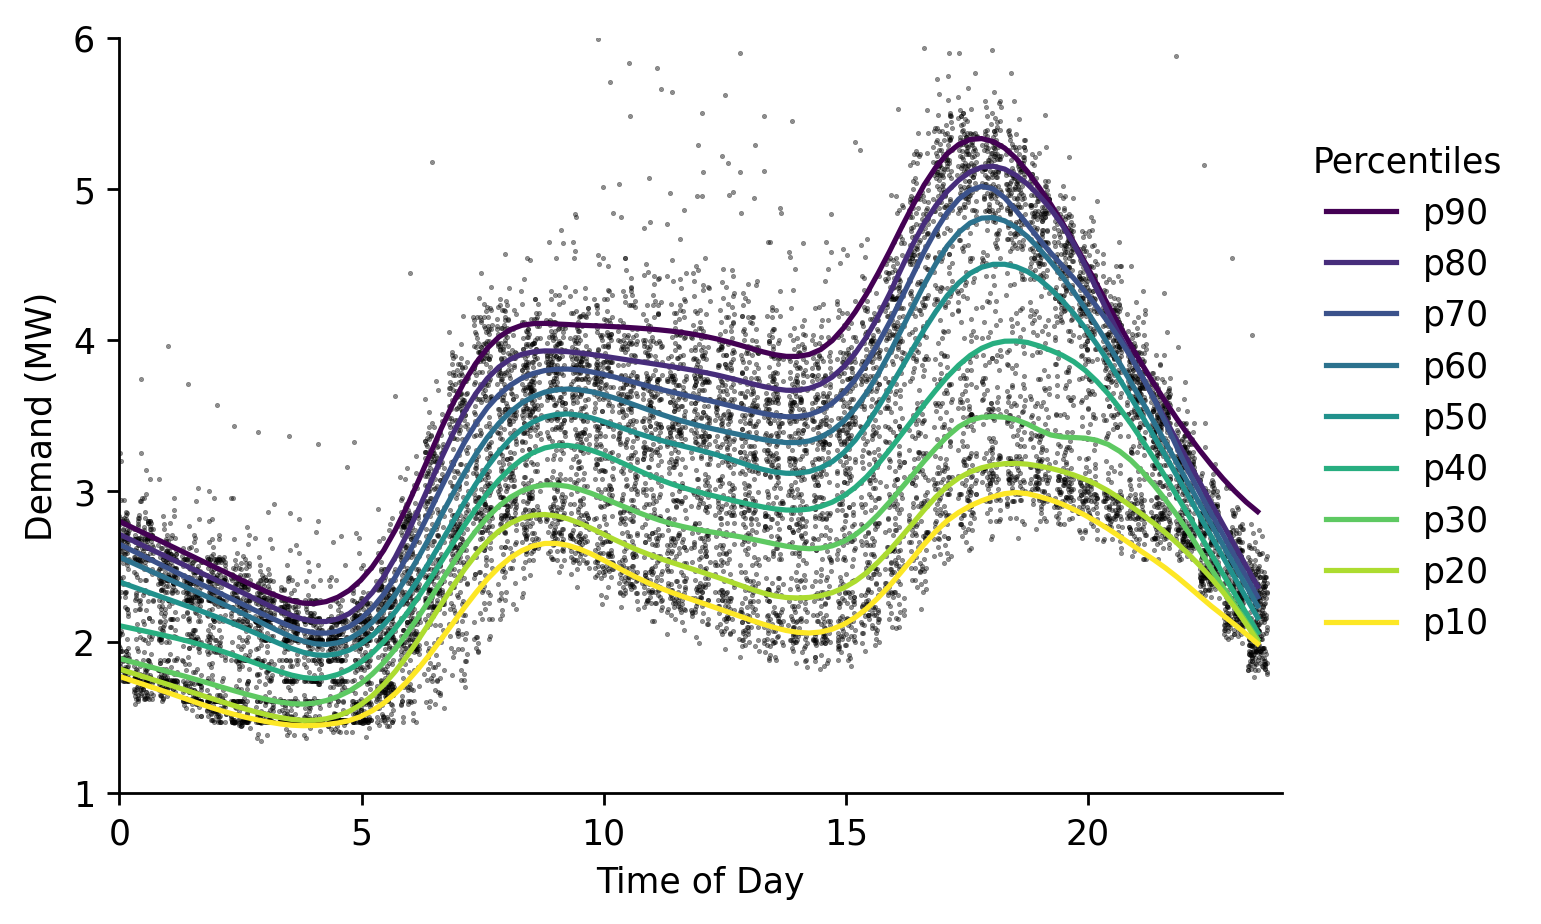

In [7]:
x_jittered = x + (np.random.uniform(size=len(x)) - 0.5)/2.5

# Plotting
fig, ax = plt.subplots(dpi=250)

ax.scatter(x_jittered, y, s=0.2, color='k', alpha=0.5)
df_quantiles.plot(cmap='viridis', legend=False, ax=ax)

hlp.hide_spines(ax)
ax.legend(frameon=False, bbox_to_anchor=(1, 0.9), title='Percentiles')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Demand (MW)')
ax.set_xlim(0, 24)
ax.set_ylim(1, 6)

fig.savefig('../img/daily_demand_profile.png')

<br>

One of the issues with the quantile fit is that it hides the a lot of the spikiness in individual daily profiles, here we'll create a function for randomly sampling days so we can visualise them alongside each other.

In [8]:
#exports
reset_idx_dt = lambda s, dt='2020-01-01': s.index - (s.index[0]-pd.to_datetime(dt, utc=True))

def sample_random_day(s):
    random_dt = random.choice(s.index.date)
    s_sample_dt = s.loc[str(random_dt)]
    
    return s_sample_dt

def sample_random_days(s, num_days=5):
    df_sample_dts = pd.DataFrame()

    for _ in range(num_days):
        s_sample_dt = sample_random_day(s)
        dt = str(s_sample_dt.index[0].date())
        s_sample_dt.index = reset_idx_dt(s_sample_dt)
        df_sample_dts[dt] = s_sample_dt
        
    df_sample_dts = df_sample_dts.sort_index(axis=1)

    return df_sample_dts

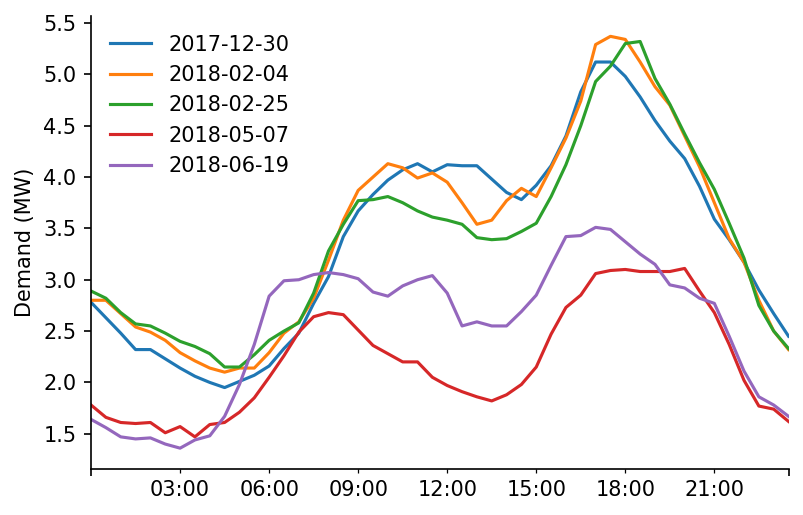

In [9]:
s_demand = df['demand_MW']
df_sample_dts = sample_random_days(s_demand)
    
# Plotting
fig, ax = plt.subplots(dpi=150)

df_sample_dts.plot(ax=ax)

ax.legend(frameon=False)
hlp.hide_spines(ax)
ax.set_xlabel('')
ax.set_ylabel('Demand (MW)')

_ = plt.setp(ax.get_xmajorticklabels(), visible=False)

<br>

### Strategy Development with Perfect Foresight

Here we'll develop a charging strategy for when we have perfect foresight, starting by sampling a random day from the demand series and then extracting the evening profile as an array from that

In [10]:
#exports
def extract_evening_demand_profile(s_demand_sample_dt, start_time='15:30', end_time='20:30'):
    dt = str(s_demand_sample_dt.index[0].date())
    evening_demand_profile = s_demand_sample_dt[f'{dt} {start_time}':f'{dt} {end_time}'].values

    return evening_demand_profile

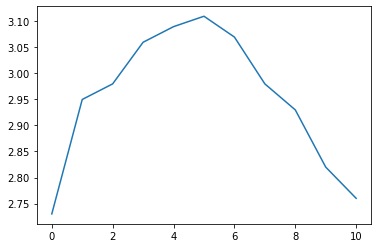

In [11]:
evening_demand_profile = sample_random_day(s_demand).pipe(extract_evening_demand_profile)

plt.plot(evening_demand_profile)

<br>

We'll then write an algorithm for peak flattening

In [12]:
#exports
def flatten_peak(evening_demand_profile, charge=6, time_unit=0.5):
    peak = max(evening_demand_profile)
    adj_evening_demand_profile = evening_demand_profile.copy()

    while charge > 0:
        num_periods_plateaued = (evening_demand_profile>=peak).sum()

        # If the evening demand profile has been fully flattened
        # then split up the remaining charge equally across all SPs
        fully_flattened = len(set(adj_evening_demand_profile)) == 1

        if fully_flattened == True:
            remaining_discharge_rate_for_each_SP = (1/time_unit)*charge/len(adj_evening_demand_profile)
            adj_evening_demand_profile -= remaining_discharge_rate_for_each_SP
            charge = 0
            break

        # If there is still a peak then determine the next highest value 
        else:
            peak = max(adj_evening_demand_profile)
            highest_non_peak = max(adj_evening_demand_profile[peak>adj_evening_demand_profile])

            proposed_additional_discharge = time_unit*(adj_evening_demand_profile.sum() - np.minimum(adj_evening_demand_profile, highest_non_peak).sum())

        # if its possible to reduce the peak to the next highest value do so
        if charge >= proposed_additional_discharge:
            adj_evening_demand_profile = np.minimum(adj_evening_demand_profile, highest_non_peak)
            charge -= proposed_additional_discharge

        # If the capacity constraints are broken when reducing to the next 
        # highest value then just lower the current peak as far as possible
        else:
            new_peak = peak - ((1/time_unit)*charge/(num_periods_plateaued+1))
            adj_evening_demand_profile = np.minimum(adj_evening_demand_profile, new_peak)
            charge = 0

    return adj_evening_demand_profile

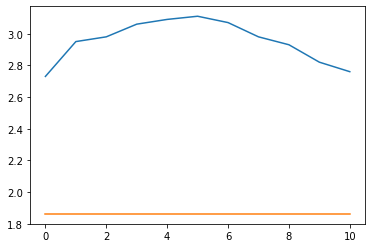

In [13]:
adj_evening_demand_profile = flatten_peak(evening_demand_profile)

plt.plot(evening_demand_profile)
plt.plot(adj_evening_demand_profile)

<br>

Which we can deduct from the original evening profile to construct the discharge profile

In [14]:
#exports
construct_discharge_profile = lambda evening_demand_profile, adj_evening_demand_profile: -(evening_demand_profile - adj_evening_demand_profile)

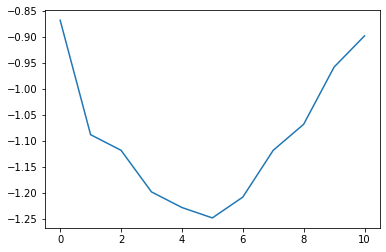

In [15]:
discharge_profile = construct_discharge_profile(evening_demand_profile, adj_evening_demand_profile)

plt.plot(discharge_profile)

<br>

Rather than the sample day we've just used we'll now repeat this step for all days we have demand data on, returning a series of the new discharge values that can be easily added to the charging values

In [16]:
#exports
def construct_discharge_s(s_demand, start_time='15:30', end_time='20:30'):
    s_discharge = pd.Series(index=s_demand.index, dtype=float).fillna(0)

    for dt in s_demand.index.strftime('%Y-%m-%d').unique():
        evening_demand_profile = s_demand[dt].pipe(extract_evening_demand_profile)
        adj_evening_demand_profile = flatten_peak(evening_demand_profile)
        
        discharge_profile = construct_discharge_profile(evening_demand_profile, adj_evening_demand_profile)
        s_discharge[f'{dt} {start_time}':f'{dt} {end_time}'] = discharge_profile

    return s_discharge

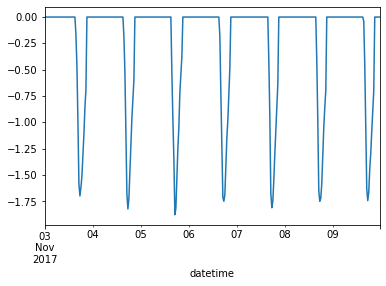

In [17]:
s_discharge = construct_discharge_s(s_demand, start_time='15:30', end_time='20:30')

s_discharge.iloc[:48*7].plot()

<br>

We can also use this discharging profile to see what the new peaks look like

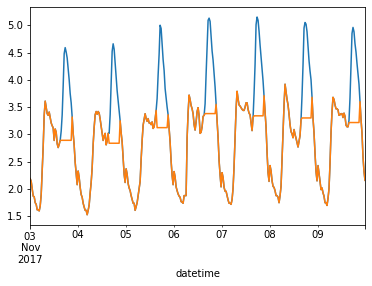

In [18]:
s_demand.iloc[:48*7].plot()
(s_demand+s_discharge).iloc[:48*7].plot()

<br>

### Strategy Development under Uncertainty

In [19]:
#exports
def construct_df_discharge_features(df):
    # Filtering for the temperature weather data
    df_features = df[df.columns[df.columns.str.contains('temp_location')]].copy()

    # Adding date features
    dts = df_features.index.tz_convert('Europe/London') # We want to use the 'behavioural' timezone

    df_features['weekend'] = dts.dayofweek.isin([5, 6]).astype(int)
    df_features['hour'] = dts.hour + dts.minute/60
    
    return df_features

In [20]:
df_features = construct_df_discharge_features(df)

df_features.head()

,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6,weekend,hour
datetime,,,,,,,,
2017-11-03 00:00:00+00:00,8.560,9.640,7.46,6.680,13.090,13.20,0,0.0
2017-11-03 00:30:00+00:00,8.625,9.675,7.30,6.475,13.150,13.26,0,0.5
2017-11-03 01:00:00+00:00,8.690,9.710,7.14,6.270,13.210,13.32,0,1.0
2017-11-03 01:30:00+00:00,8.715,9.720,7.00,6.090,13.255,13.34,0,1.5
2017-11-03 02:00:00+00:00,8.740,9.730,6.86,5.910,13.300,13.36,0,2.0


In [39]:
hour = df.index.hour+df.index.minute/60
evening_datetimes = df.index[(20.5>=hour) & (15.5<=hour)]

X = df_features.loc[evening_datetimes].values
y = s_discharge.loc[evening_datetimes].values

In [22]:
df_pred = clean.generate_kfold_preds(X, y, RandomForestRegressor(), index=evening_datetimes)

df_pred.head()

,pred,true
datetime,,
2017-11-03 15:30:00+00:00,-0.293100,-0.167273
2017-11-03 16:00:00+00:00,-0.819836,-0.467273
2017-11-03 16:30:00+00:00,-1.191645,-0.997273
2017-11-03 17:00:00+00:00,-1.571827,-1.587273
2017-11-03 17:30:00+00:00,-1.605264,-1.697273


<br>

However, in this approach there's nothing to enforce the battery constraints, namely maximum total discharge and instantaneous discharge rate. This becomes apparant when we visualise the distribution of total discharge volumes each evening.

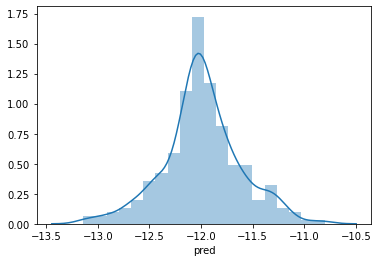

In [23]:
s_daily_discharge = df_pred['pred'].groupby(df_pred.index.date).sum()

sns.distplot(s_daily_discharge)

<br>

To account for this we can normalise each daily discharge profile by the ratio between the current total discharge and the maximum current discharge

In [24]:
#exports
def normalise_total_discharge(s_pred, charge=6, time_unit=0.5):
    s_daily_discharge = s_pred.groupby(s_pred.index.date).sum()

    for date, total_discharge in s_daily_discharge.items():
        s_pred.loc[str(date)] *= -charge/(time_unit*total_discharge)
        
    return s_pred

In [25]:
s_daily_discharge = (df_pred
                     ['pred']
                     .pipe(normalise_total_discharge)
                     .groupby(df_pred.index.date)
                     .sum()
                     .round(10)
                    )

s_daily_discharge.value_counts()

-12.0    262
Name: pred, dtype: int64

<br>

We also need to ensure that the discharge rate remains within the bounds of the problem definition, i.e. no greater than -2.5 MW

In [26]:
#exports
clip_discharge_rate = lambda s_pred, max_rate=-2.5, min_rate=0: s_pred.clip(lower=max_rate, upper=min_rate)

In [27]:
s_pred = df_pred['pred']

s_pred.head()

datetime
2017-11-03 15:30:00+00:00   -0.291893
2017-11-03 16:00:00+00:00   -0.816460
2017-11-03 16:30:00+00:00   -1.186738
2017-11-03 17:00:00+00:00   -1.565354
2017-11-03 17:30:00+00:00   -1.598652
Name: pred, dtype: object

<br>

We'll now combine these post prediction processing steps into a single function, ready to use in our model evaluation

In [28]:
#exports
post_pred_proc_func = lambda s_pred: (s_pred
                                      .pipe(normalise_total_discharge)
                                      .pipe(clip_discharge_rate)
                                     )

In [33]:
models = {
    'std_linear': LinearRegression(),
    'random_forest': RandomForestRegressor(),
    'boosted': GradientBoostingRegressor()
}

rerun_discharge_opt_model = False
discharge_opt_filename = 'discharge_optimisation_model_results.csv'

if (rerun_discharge_opt_model == True) or (discharge_opt_filename not in os.listdir(cache_data_dir)):
    df_model_scores = clean.evaluate_models(X, y, models, index=evening_datetimes, post_pred_proc_func=post_pred_proc_func)
    df_model_scores.to_csv(f'{cache_data_dir}/{discharge_opt_filename}')
else:
    df_model_scores = pd.read_csv(f'{cache_data_dir}/{discharge_opt_filename}', index_col='metric')

df_model_scores

 [████████████████████████████████████████████████████████████] 3/3 [00:11<00:03, 3.65s/it]

model,std_linear,random_forest,boosted
metric,,,
mae,0.290746,0.116488,0.131531
rmse,0.373768,0.153218,0.169413


In [35]:
top_model = df_model_scores.T['rmse'].idxmin()

df_pred = clean.generate_kfold_preds(X, y, models[top_model], index=evening_datetimes)
df_pred['pred'] = post_pred_proc_func(df_pred['pred'])

df_pred.head()

,pred,true
datetime,,
2017-11-03 15:30:00+00:00,-0.337729,-0.167273
2017-11-03 16:00:00+00:00,-0.746353,-0.467273
2017-11-03 16:30:00+00:00,-1.181042,-0.997273
2017-11-03 17:00:00+00:00,-1.613276,-1.587273
2017-11-03 17:30:00+00:00,-1.598976,-1.697273


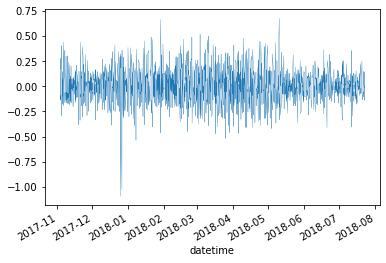

In [36]:
s_residuals = df_pred.diff(1, axis=1).dropna(axis=1).iloc[:, 0]

s_residuals.plot(linewidth=0.3)

Text(0, 0.5, 'Prediction')

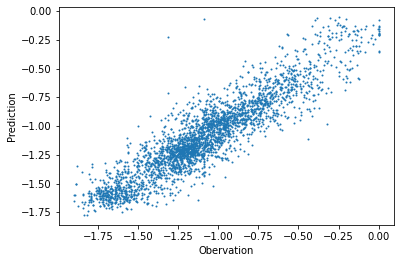

In [37]:
plt.scatter(df_pred['true'], df_pred['pred'], s=1)

plt.xlabel('Obervation')
plt.ylabel('Prediction')

In [ ]:
def evaluate_discharge_model():
    df_features = construct_df_discharge_features(df)
    s_discharge = construct_discharge_s(df['demand_MW'], start_time='15:30', end_time='20:30')
    
    hour = df.index.hour + df.index.minute/60
    evening_datetimes = df.index[(20.5>=hour) & (15.5<=hour)]
    
    X = df_features.loc[evening_datetimes].values
    y = s_discharge.loc[evening_datetimes].values
    
    df_pred = clean.generate_kfold_preds(X, y, RandomForestRegressor(), index=evening_datetimes)
    df_pred['pred'] = post_pred_proc_func(df_pred['pred'])
    
    # return pct_of_max_possible_reduction

In [53]:
def evaluate_discharge_predictions(df_pred, df, evening_datetimes):
    s_old_peaks = df['demand_MW'].loc[evening_datetimes].groupby(evening_datetimes.date).max()
    s_new_peaks = (df['demand_MW'].loc[evening_datetimes]+df_pred['pred']).groupby(evening_datetimes.date).max()
    s_optimal_peaks = (df['demand_MW'].loc[evening_datetimes]+df_pred['true']).groupby(evening_datetimes.date).max()

    s_new_peak_reduction = 100*(s_old_peaks-s_new_peaks)/s_old_peaks
    s_optimal_peak_reduction = 100*(s_old_peaks-s_optimal_peaks)/s_old_peaks
    
    # aftr cleaning anomalous demand data should add an assert to check for non finite values
    
    pct_of_max_possible_reduction = 100*(s_new_peak_reduction.replace(np.inf, np.nan).dropna().mean()/
                                         s_optimal_peak_reduction.replace(np.inf, np.nan).dropna().mean())
    
    return pct_of_max_possible_reduction

In [54]:
pct_of_max_possible_reduction = evaluate_discharge_predictions(df_pred, df, evening_datetimes)

pct_of_max_possible_reduction

85.32000756418019

In [32]:
# could use public holiday data 

In [33]:
s_new_peaks.index = pd.to_datetime(s_new_peaks.index)
s_new_peaks.loc['2018-05-08']

-0.003954545454545464

In [34]:
s_old_peaks.index = pd.to_datetime(s_old_peaks.index)
s_old_peaks.loc['2018-05-08']

0.0

<br>

Finally we'll export the relevant code to our `batopt` module

In [35]:
#hide
from nbdev.export import notebook2script
    
notebook2script()

Converted 00-utilities.ipynb.
Converted 01-data-cleaning.ipynb.
Converted 02-battery-discharge.ipynb.
Converted 03-pv-forecast.ipynb.
Converted 04-battery-optimisation.ipynb.
Converted 05-evaluation.ipynb.
Converted 06-pipeline.ipynb.
